In [11]:
import sys; sys.path.insert(0, '../')
from Toolbox import infcy
from plexsim.models import *
from plotly  import graph_objects as go
import networkx as nx

sick = dict(eta = .1, \
            beta = 1.5, \
            mu = .5)
g = nx.krackhardt_kite_graph()
# g = nx.grid_graph((4, 4))
g_prime = g.copy()
t = 1.5


for neighbor in list(g.neighbors(3))[::-2]:
    g_prime.remove_edge(3, neighbor)
models = [\
          Ising(graph = g, t = t, p_recomb = .5), \
          Ising(graph = g_prime, t = t, p_recomb = .5), \
          Pottsis(g, **sick, p_recomb = .5), \
#           Logmap(g)
          Pottsis(g_prime, **sick, p_recomb = .5)\
         ]

Logmap(g, r = 3).simulate(100).mean(0)

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])

In [12]:
results = []
for m in models:
    sim = infcy.Simulator(m)
    snapshots = sim.snapshots(n_samples = int(1e3), step = 2)
    output    = sim.forward(snapshots, repeats = int(1e3)) 
    
    results.append(\
                   dict(snapshots = snapshots, \
                conditional = output.get('conditional')))
    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:11
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:53
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:19
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:16


In [13]:
mis = []
for r in results:
    px, mi =  infcy.mutualInformation(**r)
    mis.append(mi)
    

<ipython-input-13-f5212f6389b1>:3: RuntimeWarning:

divide by zero encountered in log2

<ipython-input-13-f5212f6389b1>:3: RuntimeWarning:

invalid value encountered in multiply



In [14]:
from plotly.subplots import make_subplots

fig = make_subplots(2, 2, shared_xaxes = True,\
                   shared_yaxes = True)
for idx, mi in enumerate(mis):
    lines = []
    for node in range(models[idx].nNodes):
        line = go.Scatter(y = mi[:, node])
        lines.append(line)
    
    r, c = np.unravel_index(idx, (2, 2))
    fig.add_traces(lines, cols = c + 1, rows = r + 1)
fig.update_layout(xaxis = dict(title = 'Time [step]'),\
                 yaxis = dict(title = '$I(s_i^{t_0 + t} ; S^{t_0})$'))
fig.show()

<ipython-input-15-ae6be02e7e77>:24: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



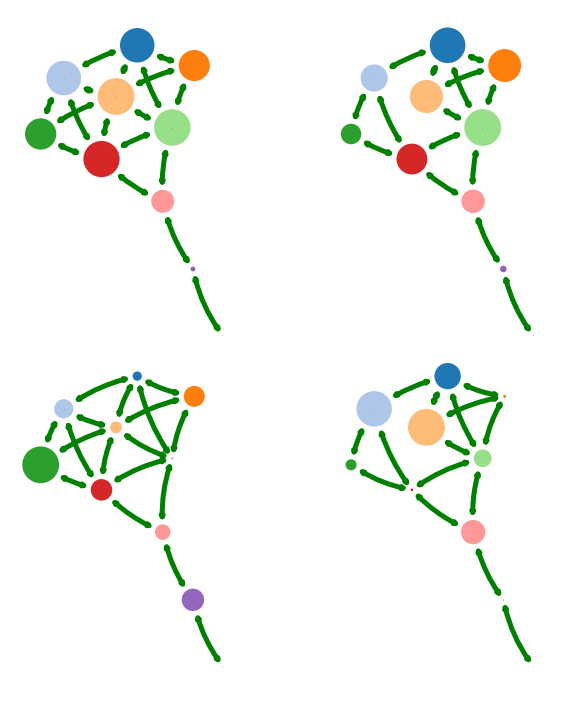

In [15]:
sizes = [mi.sum(0) for mi in mis]
import matplotlib.pyplot as plt
from Utils.plotting import addGraphPretty as agp
layout = nx.kamada_kawai_layout(models[0].graph)
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

# labels = [f"Dynamics {i}\nStructure {j}" for i, j in \
#           zip("A A B B".split(), '1 2 1 2'.split())]
for idx, axi in enumerate(ax.flat):
    agp(models[idx].graph, ax = axi, positions = layout)
    for patch in axi.patches:
        if label := patch.get_label():
                size = sizes[idx]
                size = (size - size.min()) / (size.max() - size.min()) 
                size = size[models[idx].mapping[label]]
                patch.set(radius = size * 1e-1)
        else:
            patch.set(linewidth = 5)
#             print(patch.edgewidth(10))
        axi.axis('off')
#         axi.set_title(labels[idx], color = 'white')
fig.tight_layout()
fig.subplots_adjust(wspace = -.2, hspace = -.1)
fig.show()

In [ ]:

fig.savefig('dynamics_and_structure.png', transparent = True, bbox_inches = "tight", pad_inches = 0)